# Rag From Scratch: Query Transformations

Query transformations are a set of approaches focused on re-writing and / or modifying questions for retrieval.

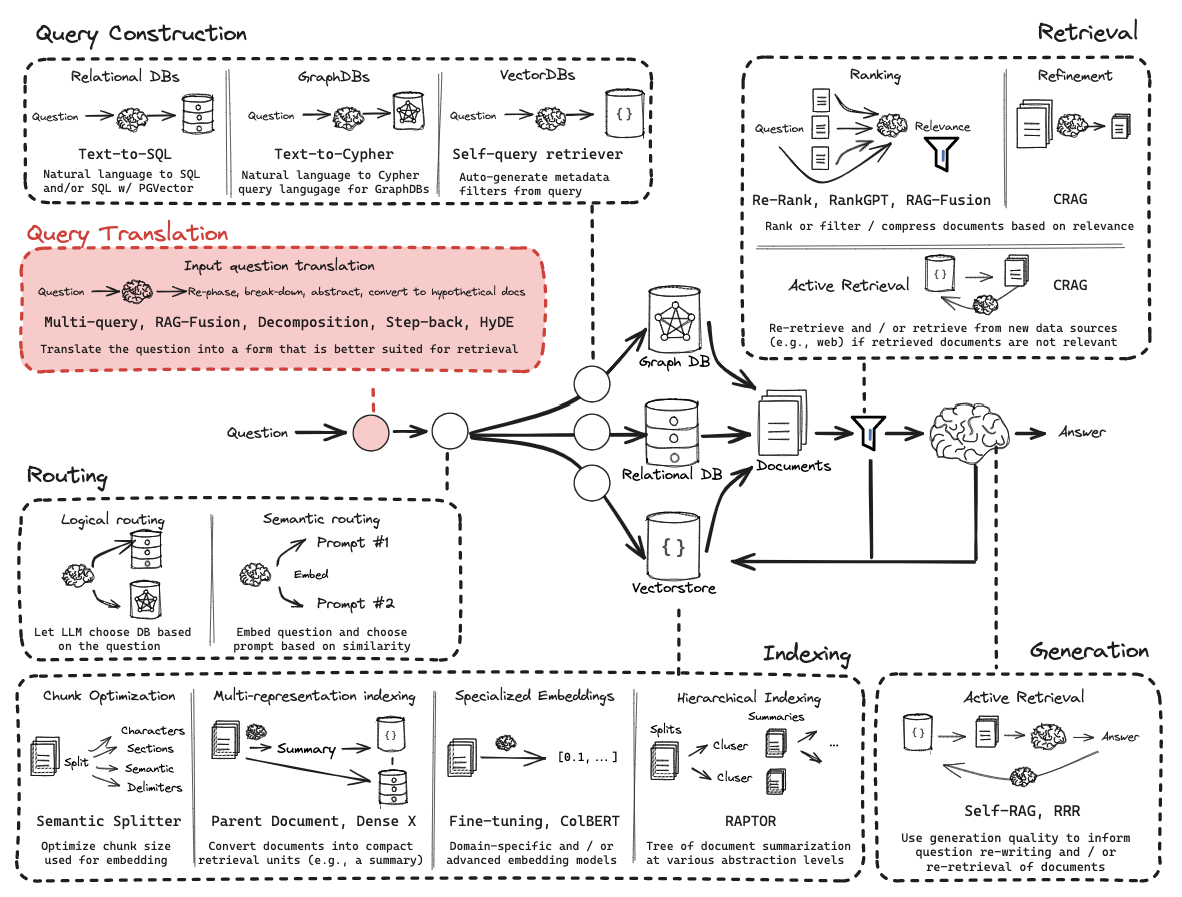

## Enviornment

`(1) Packages`

In [ ]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain

`(2) LangSmith`

https://docs.smith.langchain.com/

In [ ]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = <your-api-key>

`(3) API Keys`

In [ ]:
os.environ['OPENAI_API_KEY'] = <your-api-key>

## Part 5: Multi Query

Flow:

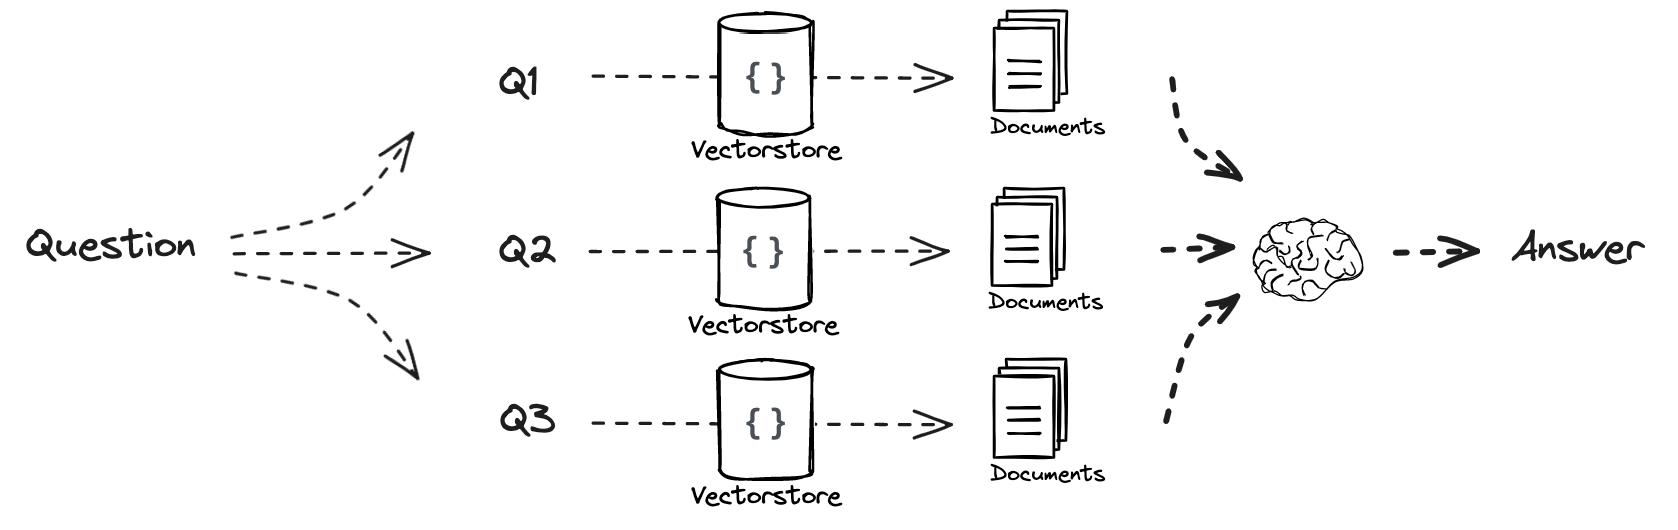

Docs:

* https://python.langchain.com/docs/modules/data_connection/retrievers/MultiQueryRetriever


Notes:
* It is a process of taking a user entered question and rewriting it into multiple questions for retrieval.
* Doing this increases the likelihood of retrieving the relevant documents.

### Index

In [ ]:
#### INDEXING ####

# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

# Index
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=OpenAIEmbeddings())

retriever = vectorstore.as_retriever()

### Prompt

In [1]:
from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_perspectives 
    | ChatOpenAI(temperature=0) 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [ ]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "What is task decomposition for LLM agents?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

In [ ]:
from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(temperature=0)

final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

## Part 6: RAG-Fusion

Flow:

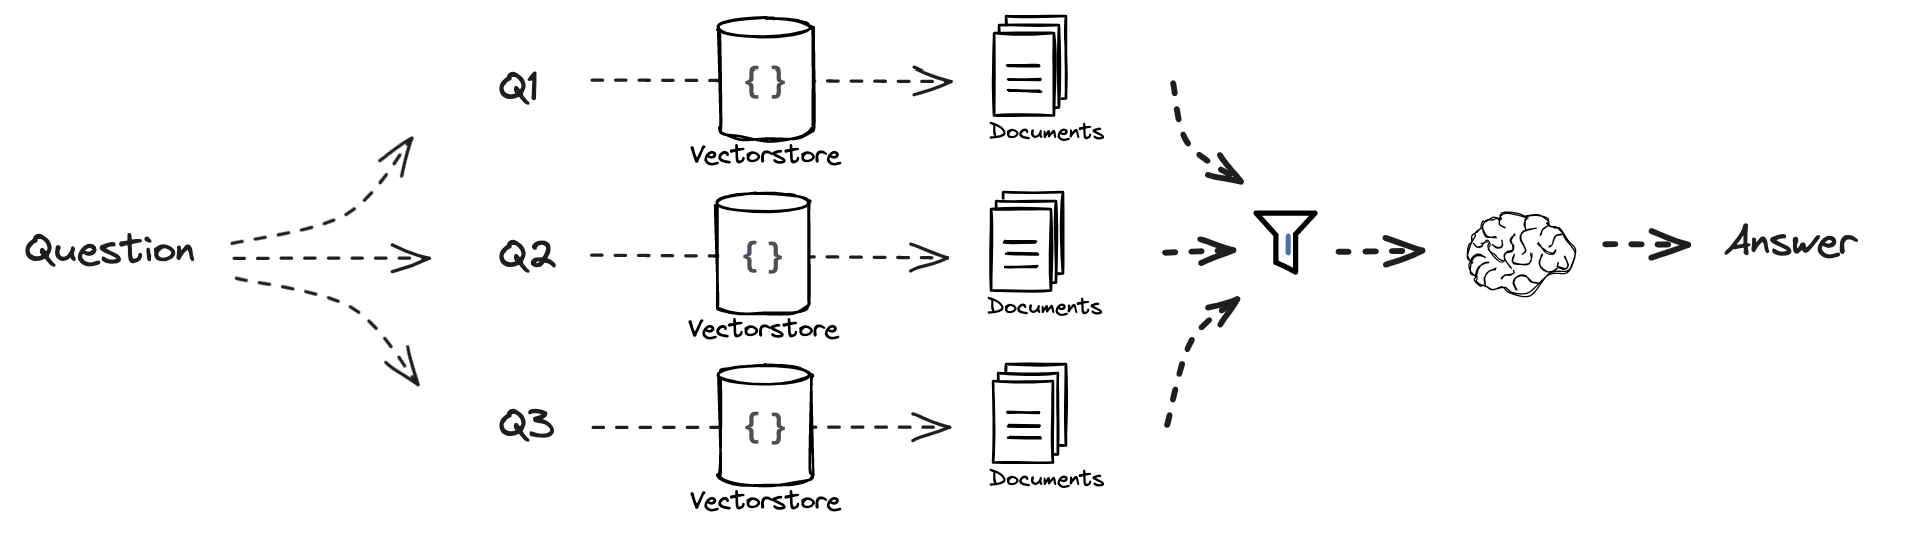

Docs:

* https://github.com/langchain-ai/langchain/blob/master/cookbook/rag_fusion.ipynb?ref=blog.langchain.dev

Blog / repo: 

* https://towardsdatascience.com/forget-rag-the-future-is-rag-fusion-1147298d8ad1

Notes:
* It is a method similar to multi query with additional task of ranking the retrieved documents.
* It takes the list of ranked documents from cosine similarity search for each (rewritten) query and combines all of them and reranks it using RRF formula.
* It helps adjusting the retrieved documents for more relevancy. 

### Prompt

In [ ]:
from langchain.prompts import ChatPromptTemplate

# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_rag_fusion 
    | ChatOpenAI(temperature=0)
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [ ]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

In [ ]:
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

Trace:

https://smith.langchain.com/public/071202c9-9f4d-41b1-bf9d-86b7c5a7525b/r

## Part 7: Decomposition


Notes:
* Decomposition is a method of breaking down a user entered question into sub-question (less abstraction) and using that for retrieval.
* For example, let's say the original query is: "What are the economic impacts of climate change on coastal cities, and how are they preparing?"
    * This query could be decomposed into:
    "What are the economic impacts of climate change on coastal cities?"
    "How are coastal cities preparing for climate change?"
    * By separating it, the system can retrieve the relevant documents for each queries effectively.

In [1]:
from langchain.prompts import ChatPromptTemplate

# Decomposition
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

In [3]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# LLM
llm = ChatOpenAI(temperature=0)

# Chain
generate_queries_decomposition = ( prompt_decomposition | llm | StrOutputParser() | (lambda x: x.split("\n")))

# Run
question = "What are the main components of an LLM-powered autonomous agent system?"
questions = generate_queries_decomposition.invoke({"question":question})

In [4]:
questions

['1. What is LLM technology and how does it work in autonomous agent systems?',
 '2. What are the specific components that make up an LLM-powered autonomous agent system?',
 '3. How do the main components of an LLM-powered autonomous agent system interact with each other to enable autonomous functionality?']

### IRCoT - Interleaving Retrieval with Chain of Thought reasoning

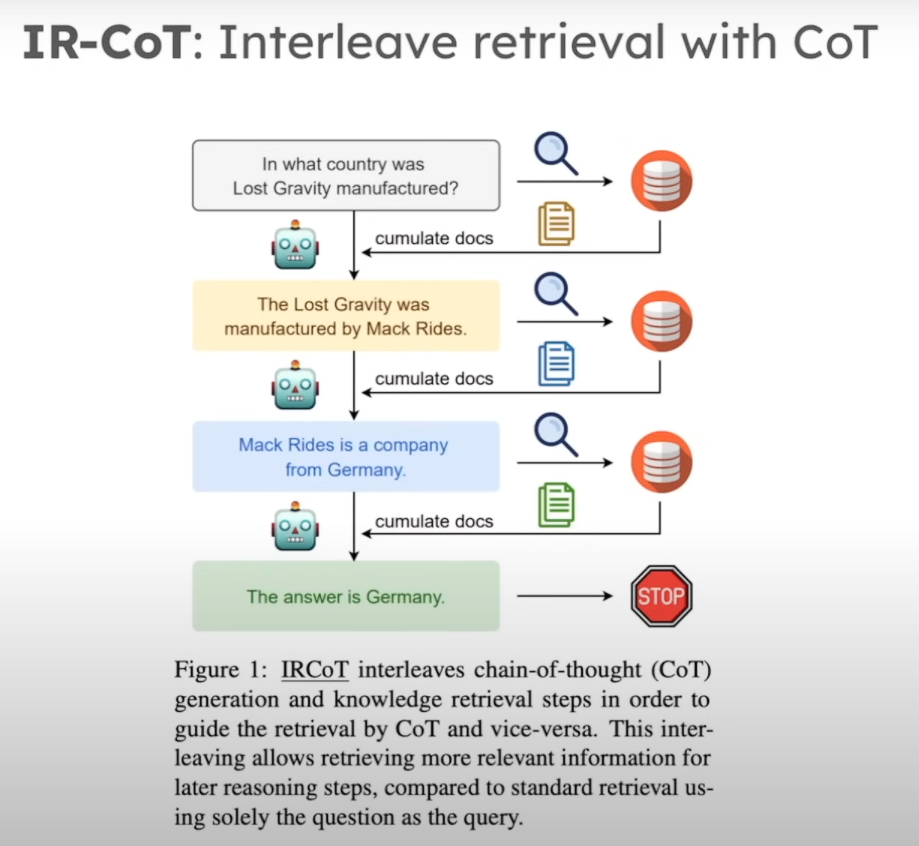

### Answer recursively  

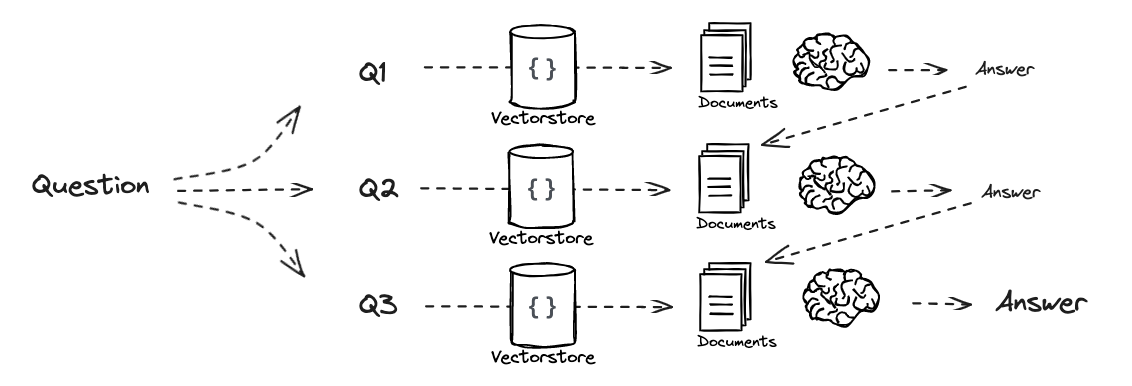

Papers:

* https://arxiv.org/pdf/2205.10625.pdf
* https://arxiv.org/abs/2212.10509.pdf


In [5]:
# Prompt
template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question: 

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

In [8]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

def format_qa_pair(question, answer):
    """Format Q and A pair"""
    
    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

# llm
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

q_a_pairs = ""
for q in questions:
    
    rag_chain = (
    {"context": itemgetter("question") | retriever, 
     "question": itemgetter("question"),
     "q_a_pairs": itemgetter("q_a_pairs")} 
    | decomposition_prompt
    | llm
    | StrOutputParser())

    answer = rag_chain.invoke({"question":q,"q_a_pairs":q_a_pairs})
    q_a_pair = format_qa_pair(q,answer)
    q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair

In [9]:
answer

'The main components of an LLM-powered autonomous agent system interact with each other in a coordinated manner to enable autonomous functionality. \n\n1. Planning: The agent breaks down complex tasks into smaller subgoals through task decomposition. This allows for efficient handling of tasks by breaking them down into manageable steps. The agent can also engage in self-reflection and refinement, learning from past actions and improving future results.\n\n2. Memory: The agent stores information and past experiences to inform future actions. This memory component helps the agent make informed decisions based on past experiences.\n\n3. External Classical Planner (LLM+P approach): In some cases, the agent may outsource long-horizon planning to an external classical planner using the Planning Domain Definition Language (PDDL) as an intermediate interface. This allows for more complex planning tasks to be handled efficiently.\n\n4. Self-Reflection (ReAct approach): The agent integrates rea

Trace: 

Question 1: https://smith.langchain.com/public/faefde73-0ecb-4328-8fee-a237904115c0/r

Question 2: https://smith.langchain.com/public/6142cad3-b314-454e-b2c9-15146cfcce78/r

Question 3: https://smith.langchain.com/public/84bdca0f-0fa4-46d4-9f89-a7f25bd857fe/r

### Answer individually 

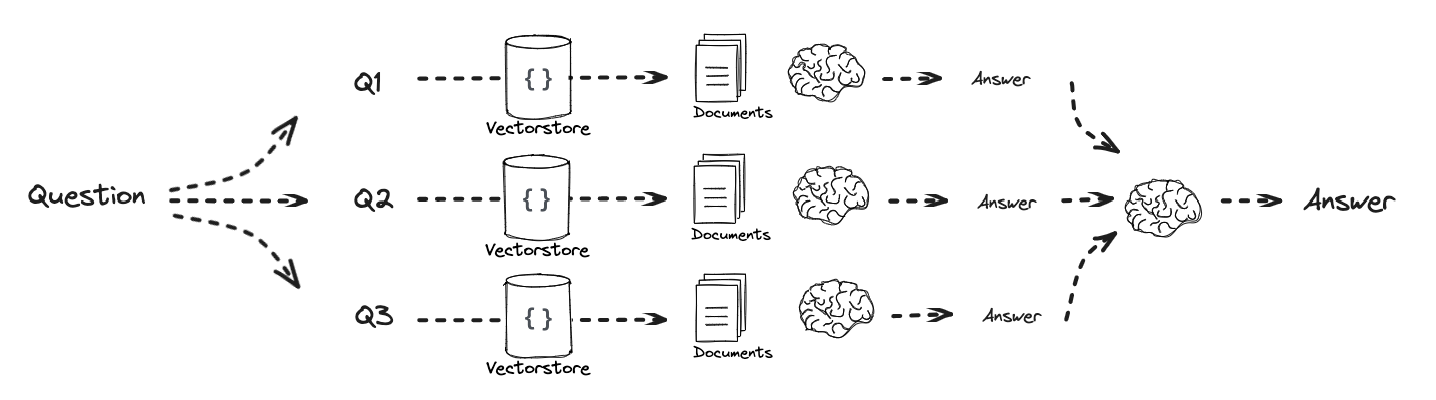

In [10]:
# Answer each sub-question individually 

from langchain import hub
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# RAG prompt
prompt_rag = hub.pull("rlm/rag-prompt")

def retrieve_and_rag(question,prompt_rag,sub_question_generator_chain):
    """RAG on each sub-question"""
    
    # Use our decomposition / 
    sub_questions = sub_question_generator_chain.invoke({"question":question})
    
    # Initialize a list to hold RAG chain results
    rag_results = []
    
    for sub_question in sub_questions:
        
        # Retrieve documents for each sub-question
        retrieved_docs = retriever.get_relevant_documents(sub_question)
        
        # Use retrieved documents and sub-question in RAG chain
        answer = (prompt_rag | llm | StrOutputParser()).invoke({"context": retrieved_docs, 
                                                                "question": sub_question})
        rag_results.append(answer)
    
    return rag_results,sub_questions

# Wrap the retrieval and RAG process in a RunnableLambda for integration into a chain
answers, questions = retrieve_and_rag(question, prompt_rag, generate_queries_decomposition)

In [11]:
def format_qa_pairs(questions, answers):
    """Format Q and A pairs"""
    
    formatted_string = ""
    for i, (question, answer) in enumerate(zip(questions, answers), start=1):
        formatted_string += f"Question {i}: {question}\nAnswer {i}: {answer}\n\n"
    return formatted_string.strip()

context = format_qa_pairs(questions, answers)

# Prompt
template = """Here is a set of Q+A pairs:

{context}

Use these to synthesize an answer to the question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context":context,"question":question})

'The main components of an LLM-powered autonomous agent system include planning, subgoal decomposition, reflection and refinement, memory, task decomposition, and self-reflection. Planning involves breaking down tasks into manageable subgoals, while reflection allows for self-criticism and learning from past actions. Task decomposition can be done through simple prompting by LLM, task-specific instructions, or human inputs. These components work together to enable autonomous behavior by allowing the agent to plan, learn from mistakes, and improve its actions over time.'

Trace:

https://smith.langchain.com/public/d8f26f75-3fb8-498a-a3a2-6532aa77f56b/r

## Part 8: Step Back

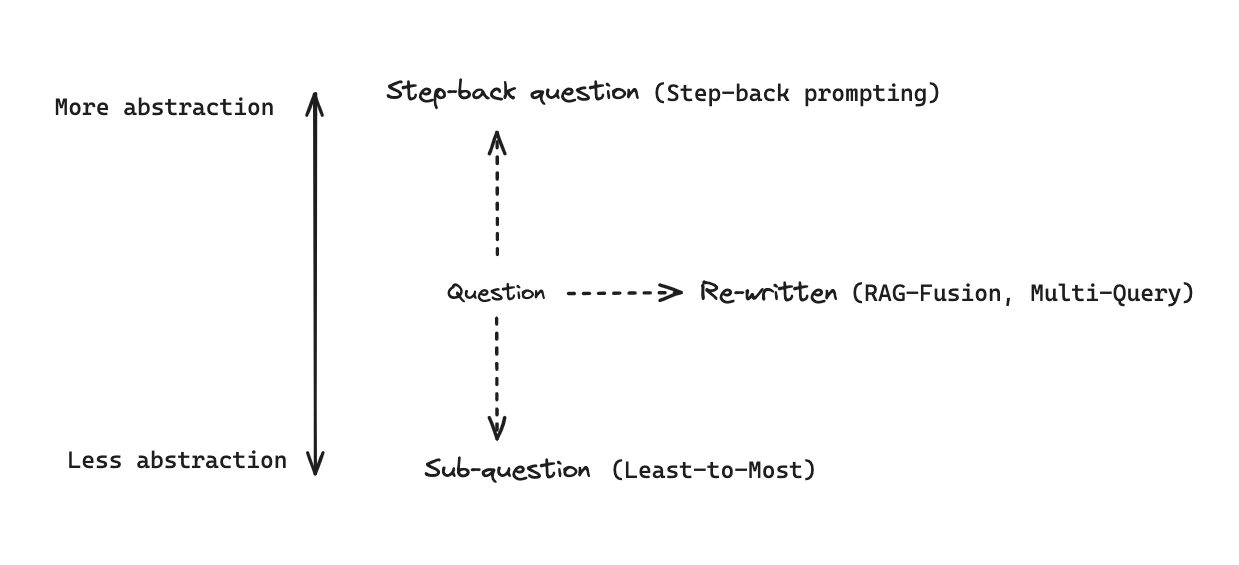

Notes:
* It is a method of abstracting the user entered query to get a more general query. It then uses the general query to retrieve the documents.
* It involves a few shot learning technique where we need to provide few examples of the required answer format in the query.
* The final answer is produced by combining both of the retrievals (normal query + generalized step-back query)
* It is particularly useful if background knowledge is needed to answer the question.


Paper: 

* https://arxiv.org/pdf/2310.06117.pdf

In [ ]:
# Few Shot Examples
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate
examples = [
    {
        "input": "Could the members of The Police perform lawful arrests?",
        "output": "what can the members of The Police do?",
    },
    {
        "input": "Jan Sindel’s was born in what country?",
        "output": "what is Jan Sindel’s personal history?",
    },
]
# We now transform these to example messages
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:""",
        ),
        # Few shot examples
        few_shot_prompt,
        # New question
        ("user", "{question}"),
    ]
)

In [ ]:
generate_queries_step_back = prompt | ChatOpenAI(temperature=0) | StrOutputParser()
question = "What is task decomposition for LLM agents?"
generate_queries_step_back.invoke({"question": question})

In [ ]:
# Response prompt 
response_prompt_template = """You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.

# {normal_context}
# {step_back_context}

# Original Question: {question}
# Answer:"""
response_prompt = ChatPromptTemplate.from_template(response_prompt_template)

chain = (
    {
        # Retrieve context using the normal question
        "normal_context": RunnableLambda(lambda x: x["question"]) | retriever,
        # Retrieve context using the step-back question
        "step_back_context": generate_queries_step_back | retriever,
        # Pass on the question
        "question": lambda x: x["question"],
    }
    | response_prompt
    | ChatOpenAI(temperature=0)
    | StrOutputParser()
)

chain.invoke({"question": question})

## Part 9: HyDE

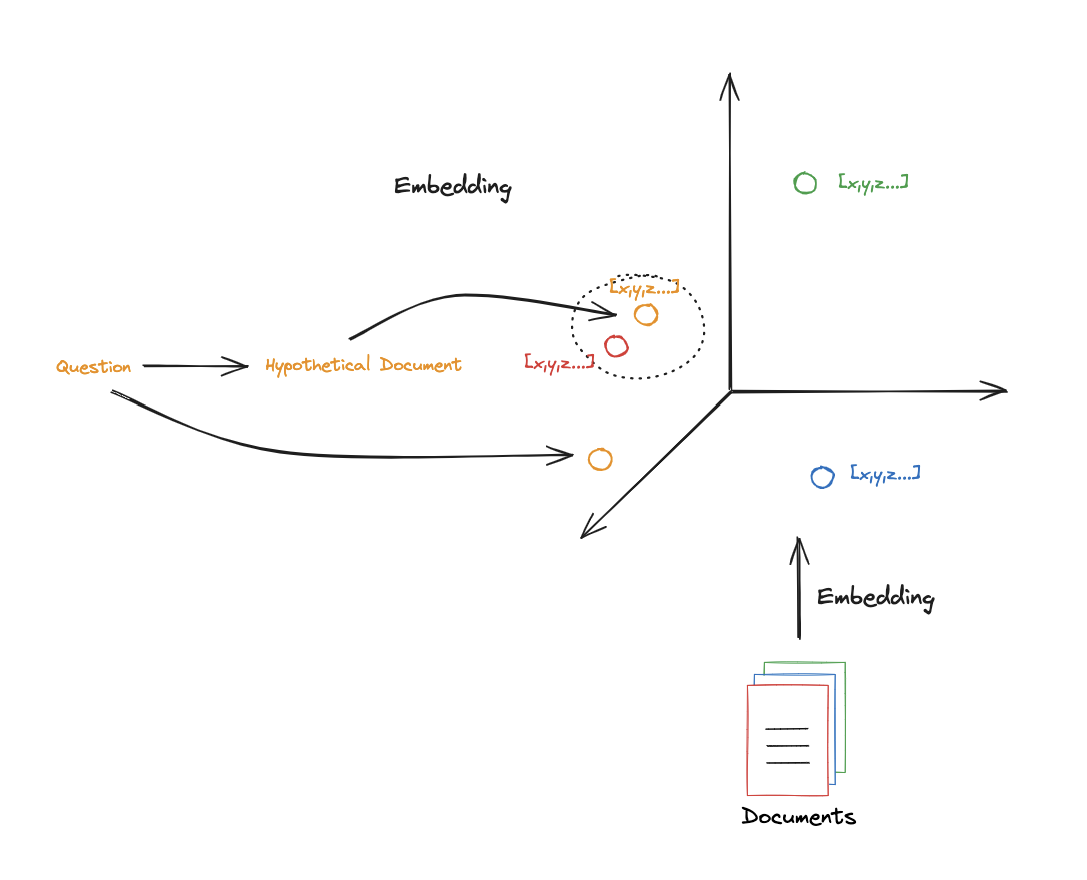

Notes:
* It is a method where the user entered query is converted into a hypothetical document (just using the LLM's world knowledge) and creating an embedding out of the document and use it for retrieval of the actual document.

Docs: 

* https://github.com/langchain-ai/langchain/blob/master/cookbook/hypothetical_document_embeddings.ipynb

Paper:

* https://arxiv.org/abs/2212.10496

In [ ]:
from langchain.prompts import ChatPromptTemplate

# HyDE document genration
template = """Please write a scientific paper passage to answer the question
Question: {question}
Passage:"""
prompt_hyde = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_docs_for_retrieval = (
    prompt_hyde | ChatOpenAI(temperature=0) | StrOutputParser() 
)

# Run
question = "What is task decomposition for LLM agents?"
generate_docs_for_retrieval.invoke({"question":question})

In [ ]:
# Retrieve
retrieval_chain = generate_docs_for_retrieval | retriever 
retireved_docs = retrieval_chain.invoke({"question":question})
retireved_docs

In [ ]:
# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context":retireved_docs,"question":question})